In [4]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import time
from utils import *
from numpy.fft import fft2, ifft2, fftshift
from SALSA import CSALSA

In [5]:
SNRdB = 40

In [6]:
img_ref = cv2.cvtColor( cv2.imread("images/cameraman.tif"), cv2.COLOR_BGR2GRAY)
M, N = img_ref.shape[:2]

In [7]:
h_blur = make_blur_kernel(51, M, blur_type=1)
HF = fft2(h_blur)

def A_op(x):
    YF = np.multiply(HF,fft2(x))
    #y = np.real( fftshift( ifft2(YF)) )
    y = np.real( ifft2(YF) )
    return y

def AT_op(x):
    YF = np.multiply(HF.conjugate(),fft2(x))
    #y = np.real( fftshift( ifft2(YF)) )
    y = np.real( ifft2(YF) )
    return y

In [8]:
y = A_op( addGaussianNoise(img_ref, SNRdB) )

In [9]:
Ax = A_op(img_ref)
sigma = np.sqrt( ((Ax-Ax.mean())**2).sum() )/np.sqrt( Ax.size*(10**(SNRdB/10))  )

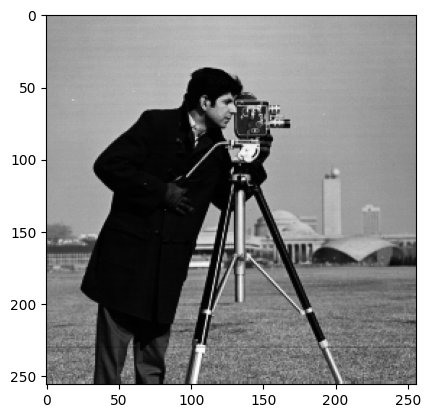

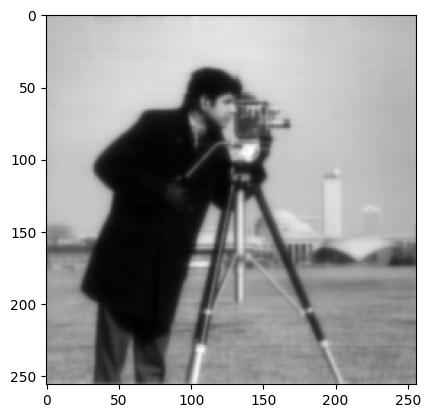

In [10]:
plt.figure(1)
plt.imshow(img_ref, cmap=plt.cm.gray)

plt.figure(2)
plt.imshow(y, cmap=plt.cm.gray)

In [11]:
# parameters
mu1 = 1
mu2 = mu1

Ny = np.product(y.shape)
epsilon = np.sqrt(Ny+8*np.sqrt(Ny))*sigma
delta = 1.01
iters = 1000
tol = 1e-4

def Phi(x):
    return TVnorm(x)

def Psi(x,th):
    return denoiseTV(x,th,chambolleit,1e-2,np.array([0]),np.array([0]))

H2 = np.abs(HF)**2


def invLS(x, mu1, mu2):
    tau = mu1/mu2
    filter_FFT = np.divide( H2, (H2 + tau) )
    return (1/mu1)*( x - np.real( ifft2( np.multiply( filter_FFT,fft2(x) ) ) ) )

In [12]:
csalsa_obj = CSALSA( y, A=A_op, AT=AT_op, invLS=invLS, mu1=mu1, mu2=mu2,\
                    sigma=sigma, Phi=Phi, Psi=Psi, isTVinitialization=1, TViters=5,\
                    delta=delta, epsilon=epsilon)

In [13]:
# usar sempre os seguintes valores "hard coded" também funciona
sigma = 0.01
epsilon = 0.144

x, objective, times, criterion, distance1, distance2, numA, numAt, mses = csalsa_obj.predict(y,\
                                                                    mu1=mu1, mu2=mu2,\
                                                                    sigma=sigma, delta=delta,\
                                                                    epsilon=epsilon, stopCriterion=3,\
                                                                     x_true=img_ref,\
                                                                     x_init=2,\
                                                                     MaxIt=iters,\
                                                                     tolA=tol,\
                                                                     verbose=0)

print ("ISNR is ",myISNR(img_ref,y,x))

ISNR is  23.447762654506885


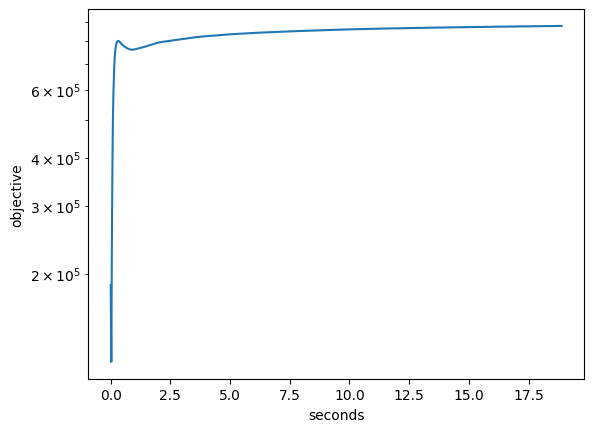

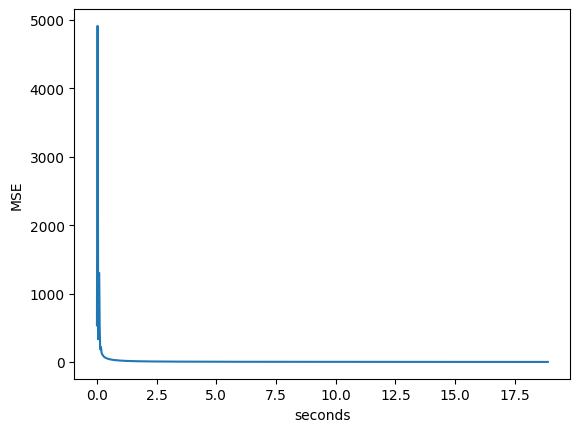

In [14]:
plt.semilogy(times,objective)
plt.xlabel('seconds')
plt.ylabel('objective')
plt.show()

plt.plot(times,mses)
plt.xlabel('seconds')
plt.ylabel('MSE')
plt.show()

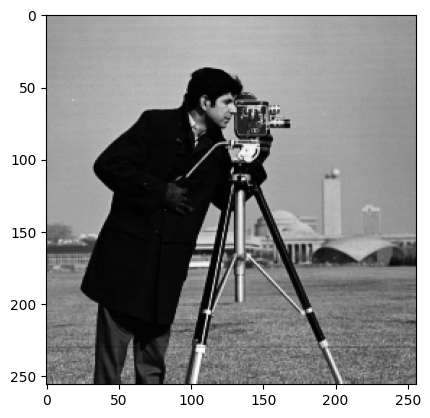

In [15]:
plt.imshow(x, cmap=plt.cm.gray)
plt.show()